<br>

<center><img src='../Header/header.png' style="width1:700px"></center>

<br>

<p style="font-size: 30px; text-align: center;"> <b>Session 2 - Geophysics</b></p>

___

# Well tie calculus

Synthetic seismograms can be created by doing basic calculus on travel-time functions. Integrating slowness (the reciprocal of velocity) can a yield a time-to-depth relationship for making a well tie. Differentiating an acoustic impedance (velocity times density) log yields a reflectivity function along the borehole, which can be convolved with a seismic wavelet. In effect, the integral tells us where a given interval of rock is in the time-domain, the derivative tells us what it should look like; its seismic character. 

Our goal is to demonstrate the robustness of simple mathematical operations with travel time.

For this tutorial, we will make use of the open-source Python libraries NumPy and Matplotlib, and the lasio library: (https://lasio.readthedocs.io/en/latest/), which is useful for reading LAS (Log ASCII Standard) files. As an example, we will use the sonic and density log from the Penobscot L-30 well.

<br>

<center><img src="offshore_well.png" style="width:850px"></center>

<br>

## Loading libraries and data

Make sure you are in the correct directory, or <code>cd</code> to the correct one. Then let's check the files. 

In [62]:
ls

data/  How_to_make_a_synthetic.pdf  NB_images/  session_2_geophysic.ipynb


Import NumPy, and the LASReader module from las.py. The las.py can be downloaded from the SciPy Cookbook (URL above), but we also give it here in the same directory. We create a well object called <code>L30</code> by passing the 'L-30.las' file into the <code>LASReader</code> module.

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [64]:
import lasio
L30 = lasio.read('./data/L-30.las')

Let's take a look at which curves are in the file,

In [65]:
print(L30.curves)

Mnemonic  Unit  Value  Description                                                    
--------  ----  -----  -----------                                                    
DEPTH:1   FT           1 Depth                                                        
CALD      IN           2 Caliper    Caliper - Density                                 
CALS      IN           3 Caliper    Caliper - Sonic                                   
DEPTH:2   FT           4 Depth                                                        
DRHO      G/CC         5 Drho       Delta Rho                                         
DT        US/F         6 Sonic      Delta-T                                           
GRD       GAPI         7 GammaRay   Gamma Ray - Density                               
GRS       GAPI         8 GammaRay   Gamma Ray - Sonic                                 
ILD       OHMM         9 DeepRes    Deep Induction Standard Processed Resistivity     
ILM       OHMM         10 MedRes     Medium

Python is an object-oriented programming language, so everything is an object, including the <code>L30</code> variable we just created. We can check the type of object by using the built-in <code>type()</code> function:

In [66]:
print(type(L30))

<class 'lasio.las.LASFile'>


The <L30> object is of type <code>lasio.LASFile</code>, which is the main class in the lasio library for handling LAS files. This class provides methods and attributes like, for example, converting the LAS data to a Pandas <code>DataFrame</code> which is similar to an Excel spreadsheet (tabular data).

In [67]:
L30DF = L30.df().reset_index()
L30DF

,DEPTH:1,CALD,CALS,DEPTH:2,DRHO,DT,GRD,GRS,ILD,ILM,LL8,NPHILS,NPHISS,RHOB,SP
0,1140.0,NaN,NaN,1140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1140.5,NaN,NaN,1140.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1141.0,NaN,NaN,1141.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1141.5,NaN,NaN,1141.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1142.0,NaN,NaN,1142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25616,13948.0,NaN,NaN,13948.0,NaN,NaN,NaN,NaN,6.005,6.537,8.120,NaN,NaN,NaN,-72.332
25617,13948.5,NaN,NaN,13948.5,NaN,NaN,NaN,NaN,5.819,6.397,7.671,NaN,NaN,NaN,-72.176
25618,13949.0,NaN,NaN,13949.0,NaN,NaN,NaN,NaN,5.857,6.317,6.890,NaN,NaN,NaN,-72.018
25619,13949.5,NaN,NaN,13949.5,NaN,NaN,NaN,NaN,5.904,6.452,6.964,NaN,NaN,NaN,-72.138


In python, we have the flexibility of creating our own functions (so called ``UDF`` - User Defined Functions). Let's create a simple function to convert depth in feet to meters.

In [68]:
def ft2m(item_in_feet):
    "converts feet to meters"
    try:
        return item_in_feet / 3.28084
    
    except TypeError:
        return float(item_in_feet) / 3.28084
    
    return converted

Create new variables by extracting data from the DataFrame and converting to SI units.

In [69]:
DEPTH = ft2m(L30DF['DEPTH:1'])    # convert feet to metres
ILD = L30DF['ILD']
DT = L30DF['DT']*3.28084   # convert usec/ft to usec/m
RHOB = L30DF['RHOB']*1000   # convert to SI units, g/cm3 to kg/m3

In [70]:
print(type(ILD))
ILD

<class 'pandas.core.series.Series'>


0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
         ...  
25616    6.005
25617    5.819
25618    5.857
25619    5.904
25620    5.953
Name: ILD, Length: 25621, dtype: float64

## Dealing with the shallow section

To deal with the shallow section, we first need to adjust the depths relative to sea level by subtracting the KB elevation (30.2 m) from the measured depths.

If we now integrate the sonic log, we see that time t = 0 corresponds to a depth of 347 m TVDss (vertical depth below MSL). To position the top of the log at the correct travel time on the seismic section, we need to use the thickness, and replacement velocities for both the water column and the overburden to estimate the TWT of the section above the log.

* The replacement velocity for water = 1480 m/s

* The replacement velocity for soft sediments, section above log = 1600 m/s

In [71]:
print(L30.well)

Mnemonic  Unit  Value                           Description                      
--------  ----  -----                           -----------                      
STRT      FT    1140.0                          START DEPTH                      
STOP      FT    13950.0                         STOP DEPTH                       
STEP      FT    0.5                             STEP VALUE                       
NULL            -999.0                          NULL VALUE                       
SRVC            SCH                             Service Company/Logging company  
DATE            08/24/2011                      LAS file Creation Date           
WELL            PENOBSCOT L-30                  Well Name                        
COMP            SHELL CANADA RESOURCES LIMITED  Company                          
FLD             Wildcat                         Field                            
STATE           Nova Scotia Shelf               State                            
COUNT           

In [72]:
# Well references in Ft. Extracting values from the well section.

KB = L30.well['KB'].value   # Kelly Bushing elevation(ft)
WD = L30.well['GL'].value  # Water Depth (ft)
LOGSS = L30.well['STRT'].value   # top of log (ft) relative to KB (actually 1150 ft)

print ("KB [Ft]: ", KB) # Kelly Bushing (Ft)
print ("WD [Ft]: ", WD) # Water Depth (Ft)
print ("LOGSS [Ft]:", LOGSS) # Log start depth below KB (Ft)

KB [Ft]:  99.0
WD [Ft]:  -451.0
LOGSS [Ft]: 1140.0


In [73]:
# Kelly Bushing TWT

water_vel = 1480  # velocity of sea water [m/s]
KB_TWT = 2.0 * np.abs(ft2m(KB)) / water_vel  # two-way travel time from KB to MSL [s]. 
# Note the function ft2m() used to convert feet to meters.
print ("KB_TWT [s]:", KB_TWT)

KB_TWT [s]: 0.04077729599242383


In [74]:
# Water TWT, measured from the KB

W_TWT = 2.0 * abs((ft2m(WD) / water_vel)) + KB_TWT
print ("W_TWT [s]:", W_TWT)

W_TWT [s]: 0.2265405332912435


In [75]:
# Replacement Interval

print('What is the sign of the Kelly Bushing KB?:', np.sign(KB))
print('What is the sign of the Water Depth WD?:', np.sign(WD), '\n')

# Subtract KB and WD from LOGSS (all in meters)
REPI = ft2m(LOGSS) - ft2m(KB) + ft2m(WD)
print ("REPI [m]:", REPI)

What is the sign of the Kelly Bushing KB?: 1.0
What is the sign of the Water Depth WD?: -1.0 

REPI [m]: 179.83199424537614


In [76]:
# Replacement Interval TWT

repl_vel = 1600 # m/s
REPI_TWT = 2.0 * REPI / repl_vel
print ("REPI_TWT [s]:", REPI_TWT) 

REPI_TWT [s]: 0.22478999280672018


In [77]:
# logs Start TWT, measured from the KB

LOGSS_TWT  = W_TWT + REPI_TWT
print ('LOGSS_TWT [s]:', LOGSS_TWT)

LOGSS_TWT [s]: 0.45133052609796365


In [78]:
# All references

print ("KB [m]: ", ft2m(KB)) # Kelly Bushing (m)
print ("KB TWT [s] :", KB_TWT, '\n')

print ("Water depth [m]: ", ft2m(WD)) # Depth to sea floor below sea level (m)
print ("Water TWT [s]: ",W_TWT, '\n')

print ("Replacement interval [m]: ", REPI)
print ("Replacement interval TWT [s]: ", REPI_TWT, '\n')

print ("Logs Start [m]: ", ft2m(LOGSS))  # top of log (m)
print ('Logs Start TWT [s]:', LOGSS_TWT)

KB [m]:  30.175199034393632
KB TWT [s] : 0.04077729599242383 

Water depth [m]:  -137.46479560112655
Water TWT [s]:  0.2265405332912435 

Replacement interval [m]:  179.83199424537614
Replacement interval TWT [s]:  0.22478999280672018 

Logs Start [m]:  347.47198888089633
Logs Start TWT [s]: 0.45133052609796365


## Fixing / editing the logs

We would like to clip spikes. But <code>np.clip()</code> clips absolute values. This won't work for us because there's a trend in the data. Instead, we'd like to compare to the neighbourhood, and clip locally spurious things. 

In [79]:
def rolling_window(a, window):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        rolled = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
        return rolled

In [80]:
a = np.array([[1, 2, 3, 4, 5, 6, 7], [6, 7, 8, 9, 10, 11, 12]])
window = 3

In [81]:
a.shape

(2, 7)

In [82]:
a.shape[:-1]

(2,)

In [83]:
a.shape[-1]

7

In [84]:
a.shape[-1] - window + 1

5

In [85]:
(a.shape[-1] - window + 1, window)

(5, 3)

In [86]:
a.shape[:-1] + (a.shape[-1] - window + 1, window)

(2, 5, 3)

In [87]:
# Test the function on the array a
rolled_a = rolling_window(a, window)
print(rolled_a)

[[[ 1  2  3]
  [ 2  3  4]
  [ 3  4  5]
  [ 4  5  6]
  [ 5  6  7]]

 [[ 6  7  8]
  [ 7  8  9]
  [ 8  9 10]
  [ 9 10 11]
  [10 11 12]]]


In [88]:
# Compute the average over the last axis
mean_rolled_a = np.mean(rolled_a, -1)
print('Mean rolled a:')
print(mean_rolled_a)
# Compute the median over the last axis
median_rolled_a = np.median(rolled_a, -1)
print('Median rolled a:')
print(median_rolled_a)

Mean rolled a:
[[ 2.  3.  4.  5.  6.]
 [ 7.  8.  9. 10. 11.]]
Median rolled a:
[[ 2.  3.  4.  5.  6.]
 [ 7.  8.  9. 10. 11.]]


Let's extract the density log from the LAS file and convert it to a numPy array.

In [89]:
type(RHOB.to_numpy())

numpy.ndarray

Now we can smooth with a rolling median filter (preserves edges, only attacks spikes). Note we are not actually going to use the smoothed version, but we are going to use the diff to decide where the spikes are.

In [90]:
window = 13  # longitud de la ventana (~2 m)
print('Original RHOB.shape:', RHOB.shape)
RHOB_SM = np.median(rolling_window(RHOB.to_numpy(), window), -1) # -1 refers to the last axis
print('Previous RHOB_SM.shape:', RHOB_SM.shape)
RHOB_SM = np.pad(RHOB_SM, window // 2, mode='edge')
print('New RHOB_SM.shape:', RHOB_SM.shape)

Original RHOB.shape: (25621,)
Previous RHOB_SM.shape: (25609,)
New RHOB_SM.shape: (25621,)


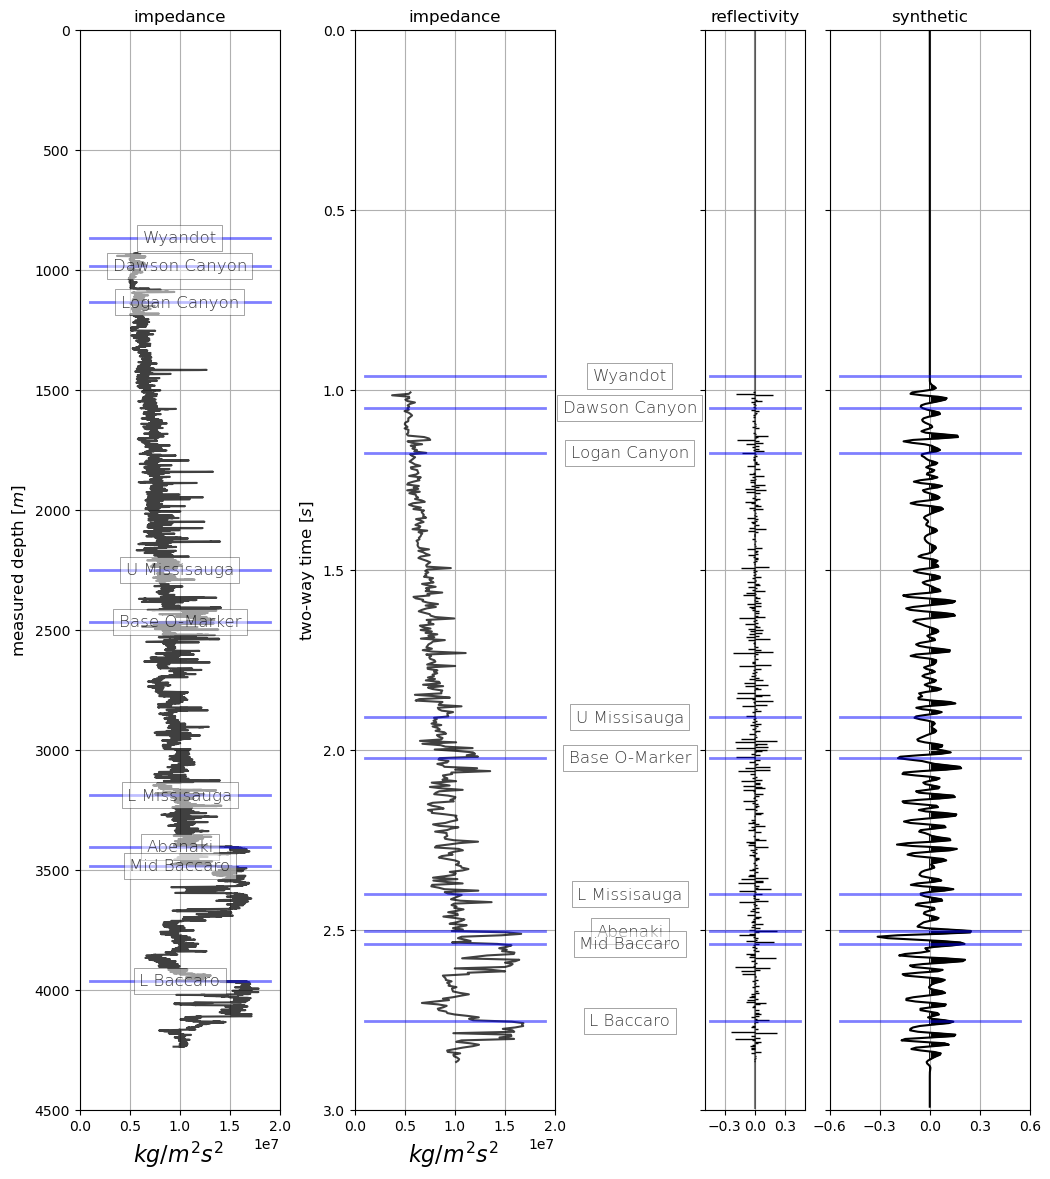

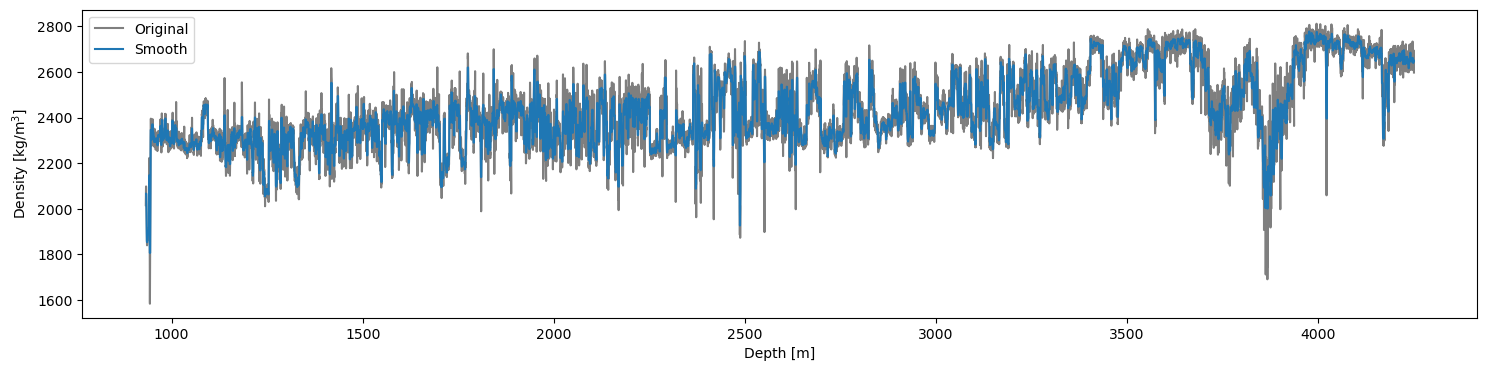

In [91]:
plt.figure(figsize=(18,4))
plt.plot(DEPTH, RHOB, 'k', alpha=0.5, label='Original')
plt.plot(DEPTH, RHOB_SM, label='Smooth')
plt.xlabel('Depth [m]')
plt.ylabel('Density [kg/m$^3$]')
plt.legend()
plt.show()

Now we will find spikes by comparing the original data with the median-smoothed data. If they differ by more than 100 (arbitrary), then it's a spike. Alternately, we could use the DRHO curve as a threshold for this:

In [92]:
def despike(curve, curve_sm, max_clip): 
    spikes = np.where(curve - curve_sm > max_clip)[0]
    spukes = np.where(curve_sm - curve > max_clip)[0]
    out = np.copy(curve)
    out[spikes] = curve_sm[spikes] + max_clip  # Clip at the max allowed diff
    out[spukes] = curve_sm[spukes] - max_clip  # Clip at the min allowed diff
    return out

Now we know the indices of the spiky data, we can replace with a clipped version of the same spike. 

In [93]:
RHOB_DESP = despike(RHOB, RHOB_SM, max_clip = 100)

Let's examine a segment of the log to see what effect it had,

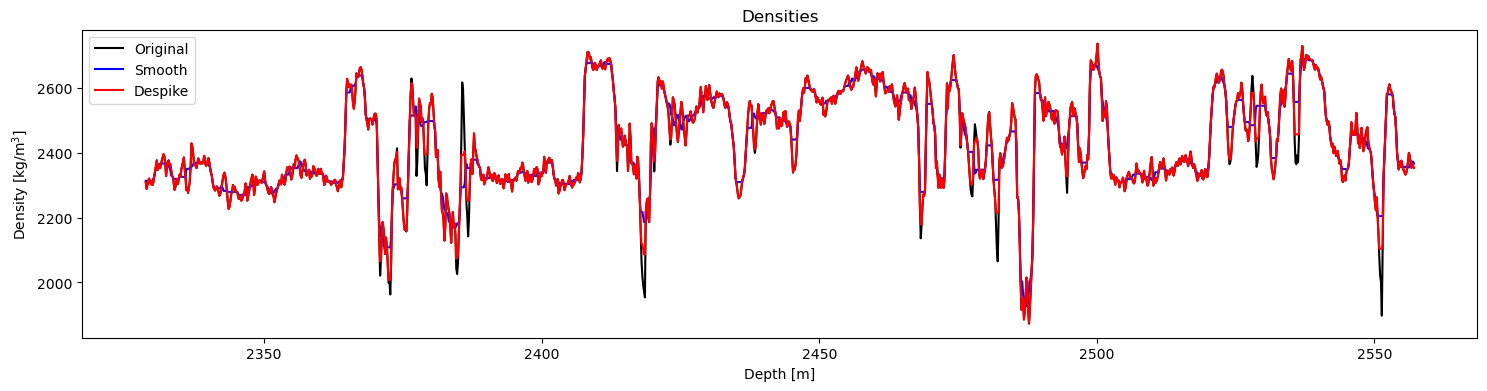

In [94]:
start = 13000
end = 14500

plt.figure(figsize=(18,4))
plt.plot(DEPTH[start:end], RHOB[start:end],'k', label='Original')
plt.plot(DEPTH[start:end], RHOB_SM[start:end],'b', label='Smooth')
plt.plot(DEPTH[start:end], RHOB_DESP[start:end],'r', label='Despike')
plt.xlabel('Depth [m]')
plt.ylabel('Density [kg/m$^3$]')
plt.legend()
plt.title('Densities')
plt.show()

Do the same thing for the sonic log,

In [95]:
DT_SM = np.median(rolling_window(DT.to_numpy(), window), -1)
DT_SM = np.pad(DT_SM, window//2, mode='edge')
DT_DESP = despike(DT, DT_SM, max_clip = 10)

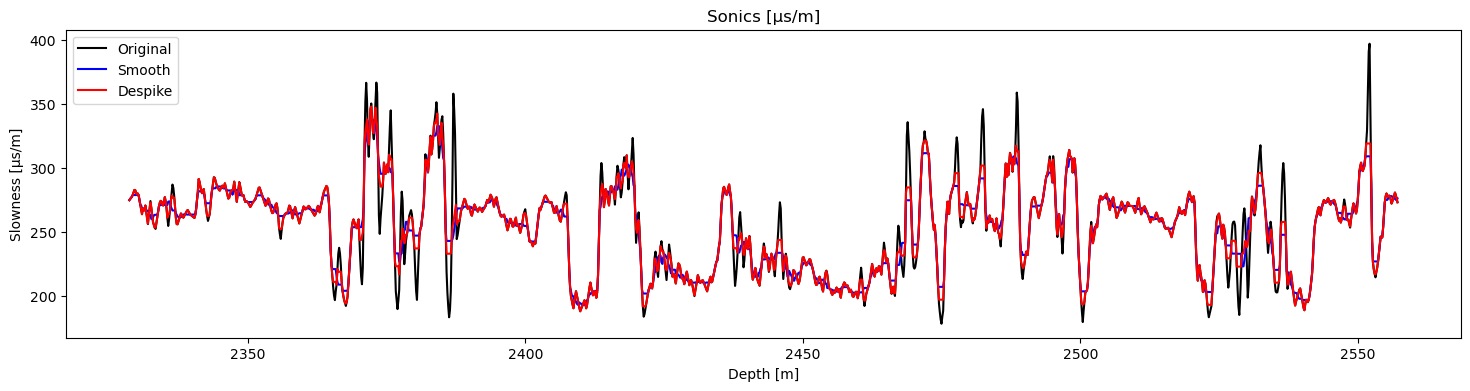

In [96]:
start = 13000
end = 14500

plt.figure(figsize=(18,4))
plt.plot(DEPTH[start:end], DT[start:end],'k', label='Original')
plt.plot(DEPTH[start:end], DT_SM[start:end],'b', label='Smooth')
plt.plot(DEPTH[start:end], DT_DESP[start:end],'r', label='Despike')
plt.xlabel('Depth [m]')
plt.ylabel('Slowness [μs/m]')
plt.legend()
plt.title('Sonics [μs/m]')
plt.show()

### Computing the time-to-depth relationship

The time-to-depth relationship is obtained by scaling the sonic log by the sample interval (6" or 0.1524 m) and by calling <code>np.cumsum()</code> on it.

In [97]:
DT

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
25616   NaN
25617   NaN
25618   NaN
25619   NaN
25620   NaN
Name: DT, Length: 25621, dtype: float64

In [98]:
# two-way-time to depth relationship

DT_SCALED = 0.1524 * np.nan_to_num(DT) / 1e6

TCUM = 2 * np.cumsum(DT_SCALED)
TDR = LOGSS_TWT + TCUM

### Compute acoustic impedance

In [99]:
Z = (1e6/DT_DESP) * RHOB_DESP
Z

array([nan, nan, nan, ..., nan, nan, nan])

### Compute reflection coefficient series

In [100]:
Z[1:] 

array([nan, nan, nan, ..., nan, nan, nan])

In [101]:
Z[:-1] 

array([nan, nan, nan, ..., nan, nan, nan])

In [102]:
RC = (Z[1:] - Z[:-1]) / (Z[1:] + Z[:-1])
RC

array([nan, nan, nan, ..., nan, nan, nan])

### Get well tops

Let's make a dictionary from the file 'tops.txt'

In [103]:
# Get well tops for plot annotation
tops = {}

with open('./data/tops.txt') as f:
    for line in f.readlines():
        if not line.startswith('#'):
            temp = line.strip().split('\t')
            tops[temp[-1].replace('_',' ')] = float(temp[1])
            
tops

{'Wyandot': 867.156,
 'Dawson Canyon': 984.504,
 'Logan Canyon': 1136.904,
 'U Missisauga': 2251.253,
 'Base O-Marker': 2469.207,
 'L Missisauga': 3190.646,
 'Abenaki': 3404.311,
 'Mid Baccaro': 3485.083,
 'L Baccaro': 3964.534}

In [104]:
tops.items() , tops.values()

(dict_items([('Wyandot', 867.156), ('Dawson Canyon', 984.504), ('Logan Canyon', 1136.904), ('U Missisauga', 2251.253), ('Base O-Marker', 2469.207), ('L Missisauga', 3190.646), ('Abenaki', 3404.311), ('Mid Baccaro', 3485.083), ('L Baccaro', 3964.534)]),
 dict_values([867.156, 984.504, 1136.904, 2251.253, 2469.207, 3190.646, 3404.311, 3485.083, 3964.534]))

Find top relative to nearest sample in time domain

In [105]:
a.argmin()

0

In [106]:
a.argmax()

13

In [107]:
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

For plotting tops in the time-domain, make a second entry in the dictionary for the travel-time.

In [108]:
tops.items()

dict_items([('Wyandot', 867.156), ('Dawson Canyon', 984.504), ('Logan Canyon', 1136.904), ('U Missisauga', 2251.253), ('Base O-Marker', 2469.207), ('L Missisauga', 3190.646), ('Abenaki', 3404.311), ('Mid Baccaro', 3485.083), ('L Baccaro', 3964.534)])

In [109]:
tops_twt = {}

for key, val in tops.items():
    tops_twt[key] = TDR[find_nearest(DEPTH, val)]
    
tops_twt

{'Wyandot': 0.9628054164651595,
 'Dawson Canyon': 1.0501182740591708,
 'Logan Canyon': 1.1753385380662213,
 'U Missisauga': 1.9107363916989557,
 'Base O-Marker': 2.0239985743233464,
 'L Missisauga': 2.4023350494301106,
 'Abenaki': 2.505314397725444,
 'Mid Baccaro': 2.5390761738058227,
 'L Baccaro': 2.7534187893647895}

### Code to create figure

Plot the logs in the depth domain

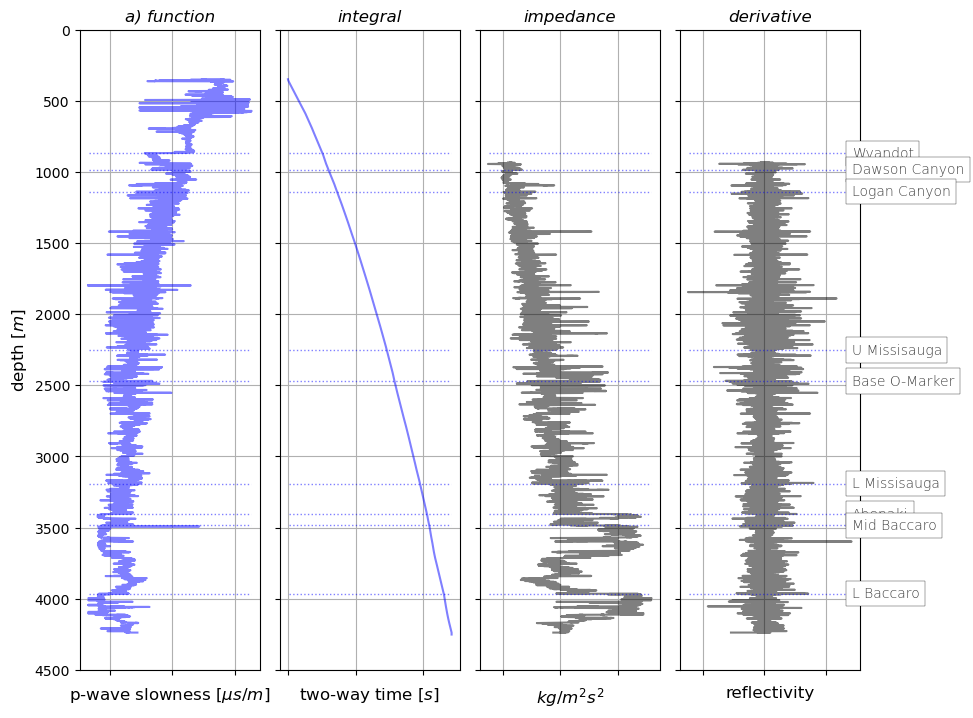

In [110]:
f1 = plt.figure(figsize = (10,8))

ax1 = f1.add_axes([0.1, 0.1, 0.18, 0.8])
ax1.plot(DT, DEPTH,'b', alpha=0.5)
ax1.set_title('a) function', style = 'italic')
ax1.set_ylabel('depth ' + '$[m]$', fontsize = '12' )
ax1.set_xlabel('p-wave slowness '+ r'$[\mu s/m]$', fontsize = '12')
ax1.set_ylim(0, 4500)
ax1.set_xticklabels('')
ax1.invert_yaxis()
ax1.grid()

ax2 = f1.add_axes([0.3 , 0.1, 0.18, 0.8])
ax2.plot(TCUM, DEPTH, 'b', alpha = 0.5)
ax2.set_title('integral', style = 'italic')
ax2.set_xlabel('two-way time ' + '$[s]$', fontsize = '12')
ax2.invert_yaxis()
ax2.set_yticklabels('')
ax2.set_xticklabels('')
ax2.set_ylim(4500, 0)
ax2.grid()

ax3 = f1.add_axes([0.5, 0.1, 0.18, 0.8])
ax3.plot( Z, DEPTH, 'k', alpha=0.5)
ax3.set_title('impedance', style = 'italic')
ax3.set_xlabel(r'$kg/m^2s^2$', fontsize = '12')
ax3.invert_yaxis()
ax3.set_yticklabels('')
ax3.set_xticklabels('')
ax3.set_ylim(4500, 0)
ax3.grid()

ax4 = f1.add_axes([0.7, 0.1, 0.18, 0.8])
ax4.plot( RC, DEPTH[:-1], 'k', alpha=0.5)
ax4.set_title('derivative', style = 'italic')
ax4.set_xlabel('reflectivity', fontsize = '12')
ax4.invert_yaxis()
ax4.set_yticklabels('')
ax4.set_xticklabels('')
ax4.set_ylim(4500, 0)
ax4.grid()

for i in range (4):
    for top in tops.values() :
        f1.axes[i].axhline( y = float(top), color = 'b', lw = 1, 
                            ls = ':',  
                            alpha = 0.5, xmin = 0.05, xmax = 0.95 )

for top, depth in tops.items():
    ax4.text( x = max(ax4.xaxis.get_data_interval())*1.0,
              y = float(depth), s = top,
                         alpha=0.75, color='k',
                         fontsize = '10',
                         horizontalalignment = 'left',
                         verticalalignment = 'center',
                         bbox=dict(facecolor='white', alpha=1.0, lw = 0.25),
                         weight = 'light')

ax5 = f1.add_axes([0.8, 0.1, 0.18, 0.8])
ax5.invert_yaxis()
ax5.set_ylim(4500, 0)
ax5.set_axis_off()

plt.show()

### Converting logs to two-way-travel time

But we need the functions represented by travel time

In [111]:
# RESAMPLING FUNCTION
dt = 0.004    # intervalo de muestreo de la sismica
maxt = 3.0    # tiempo de muestreo de la sismica

t = np.arange(0, maxt, dt) 

Z_t = np.interp(x = t, xp = TDR, fp = Z)

RC_t = (Z_t[1:] - Z_t[:-1]) / (Z_t[1:] + Z_t[:-1])

In [112]:
type(RC_t)

numpy.ndarray

In [113]:
Z_t[1:]

array([              nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               

In [114]:
Z_t[:-1]

array([              nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               nan,               nan,
                     nan,               

## Creating the synthetic

In [115]:
# # Define a wavelet.
# def ricker(f, length, dt):
#     t = np.linspace(-length / 2, (length-dt) / 2, length / dt)
#     y = (1. - 2.*(np.pi**2)*(f**2)*(t**2))*np.exp(-(np.pi**2)*(f**2)*(t**2))
#     return t, y

In [116]:
import numpy as np

def ricker(f, length, dt):
    """
    Genera una onda de Ricker (wavelet sísmica) de frecuencia dominante f.

    Parámetros
    ----------
    f : float
        Frecuencia dominante (Hz)
    length : float
        Duración total de la onda (segundos)
    dt : float
        Intervalo de muestreo (segundos)

    Retorna
    -------
    t : ndarray
        Vector de tiempo (s)
    w : ndarray
        Amplitud de la onda de Ricker
    """
    n_samples = int(length / dt)           # número de muestras
    t = np.linspace(-length / 2, (length - dt) / 2, n_samples)
    y = (1. - 2. * (np.pi**2) * (f**2) * (t**2)) * np.exp(-(np.pi**2) * (f**2) * (t**2))
    return t, y


In [117]:
RC_t = np.nan_to_num(RC_t)
tw, w = ricker (f=25, length = 0.512, dt = 0.004)
synth = np.convolve(RC_t, w, mode='same')

In [118]:
# RC_t = np.nan_to_num(np.asarray(RC_t))     # limpiar y asegurar tipo array
# tw, w = ricker(f=25, length=0.512, dt=0.004)
# synth = np.convolve(RC_t, w, mode='same')  # orden correcto

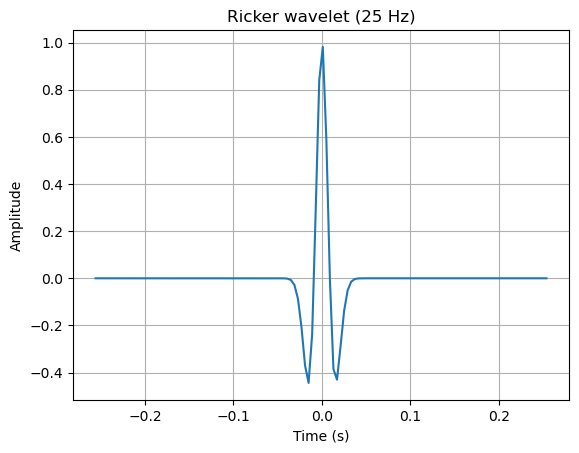

In [119]:
import matplotlib.pyplot as plt

plt.plot(tw, w)
plt.title("Ricker wavelet (25 Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


### Code to create figure

In [120]:
f2 = plt.figure(figsize=[10,12])

ax1 = f2.add_axes([0.05, 0.1, 0.2, 0.9])
ax1.plot(Z, DEPTH,'k', alpha=0.75)
ax1.set_title('impedance')
ax1.set_ylabel('measured depth ' + '$[m]$', fontsize = '12' )
ax1.set_xlabel(r'$kg/m^2s^2$ ', fontsize = '16')
ax1.set_ylim(0, 4500)
ax1.set_xticks( [0.0e7, 0.5e7, 1.0e7, 1.5e7, 2.0e7 ] )
ax1.invert_yaxis()
ax1.grid()

ax2 = f2.add_axes([0.325, 0.1, 0.2, 0.9])
ax2.plot(Z_t, t,'k', alpha=0.75)
ax2.set_title('impedance')
ax2.set_ylabel('two-way time ' + '$[s]$', fontsize = '12' )
ax2.set_xlabel(r'$kg/m^2s^2$ ', fontsize = '16')
ax2.set_ylim(0, 3)
ax2.set_xticks( [0.0e7, 0.5e7, 1.0e7, 1.5e7, 2.0e7 ] )
ax2.invert_yaxis()
ax2.grid()

ax3 = f2.add_axes([0.675, 0.1, 0.1, 0.9])
ax3.hlines(t[:-1], 0, RC_t, color='k', lw = 1)                    # Stems
ax3.plot([0, 0], [t.min(), t.max()], '-', c='k', alpha = 0.5)     # Middle bar
ax3.set_title('reflectivity')
ax3.set_xlabel('', fontsize = '10')
ax3.set_ylim(0, 3)
ax3.set_xlim(-0.5, 0.5)
ax3.invert_yaxis()
ax3.set_yticklabels('')
ax3.set_xticks([-0.3, 0, 0.3] )
ax3.grid()

ax4 = f2.add_axes([0.8, 0.1, 0.2, 0.9])
ax4.plot(synth, t[:-1],'k')
ax4.fill_betweenx(t[:-1], synth,  0,  synth > 0.0,  color='k', alpha = 1.0)
ax4.set_title('synthetic')
ax4.set_xlabel('', fontsize = '10')
ax4.set_ylim(0, 3)
ax4.set_xlim(-0.05, 0.05)
ax4.invert_yaxis()
ax4.set_yticklabels('')
ax4.set_xticks([-0.6, -0.3, 0, 0.3, 0.6 ] )
ax4.grid()

for i in range(1):
    for top, depth in tops.items():
        f2.axes[i].axhline( y = float(depth), color = 'b', lw = 2, 
                            alpha = 0.5, xmin = 0.05, xmax = 0.95 )
        f2.axes[i].text( x = 1e7, y = float(depth)-0.015, s = top,
                         alpha=0.75, color='k',
                         fontsize = '12',
                         horizontalalignment = 'center',
                         verticalalignment = 'center',
                         bbox=dict(facecolor='white', alpha=0.5, lw = 0.5),
                         weight = 'light')
        

for i in range(1,4):
    for twt in tops_twt.values():
        f2.axes[i].axhline( y = float(twt), color = 'b', lw = 2, 
                    alpha = 0.5, xmin = 0.05, xmax = 0.95)
for i in range(1,2):
    for top, twt in tops_twt.items():
        f2.axes[i].text( x = 2.75e7, y = float(twt), s = top,
                         alpha=0.75, color='k',
                         fontsize = '12',
                         horizontalalignment = 'center',
                         verticalalignment = 'center',
                         bbox=dict(facecolor='white', alpha=0.5, lw = 0.5),
                         weight = 'light'
                         )

In [121]:
print(len(Z), len(DEPTH))
print(len(Z_t), len(t))
print(len(RC_t), len(t[:-1]))
print(len(synth), len(t[:-1]))

25621 25621
750 750
749 749
749 749


## Comparison with real data

real data is located at trace 77 of 500

In [122]:
traces = np.loadtxt('./data/PenobXL_1155.txt')

# rearrange traces for plotting
traces_64 = np.fliplr(np.transpose(traces))
traces_16 = np.fliplr(np.transpose(traces)).astype(np.int16)

In [123]:
# Compare sizes
print('traces_64 size:', traces_64.nbytes)
print('traces_16 size:', traces_16.nbytes)

traces_64 size: 3217624
traces_16 size: 804406


In [124]:
# Check if max and min of both arrays are the same
print('traces_64 max:', traces_64.max(), ' min:', traces_64.min(), ' mean:', traces_64.mean())
print('traces_16 max:', traces_16.max(), ' min:', traces_16.min(), ' mean:', traces_16.mean())

traces_64 max: 25210.0  min: -18392.0  mean: -0.8658562964473164
traces_16 max: 25210  min: -18392  mean: -0.8658562964473164


In [125]:
traces = traces_16
del traces_64, traces_16

### Code to create figure

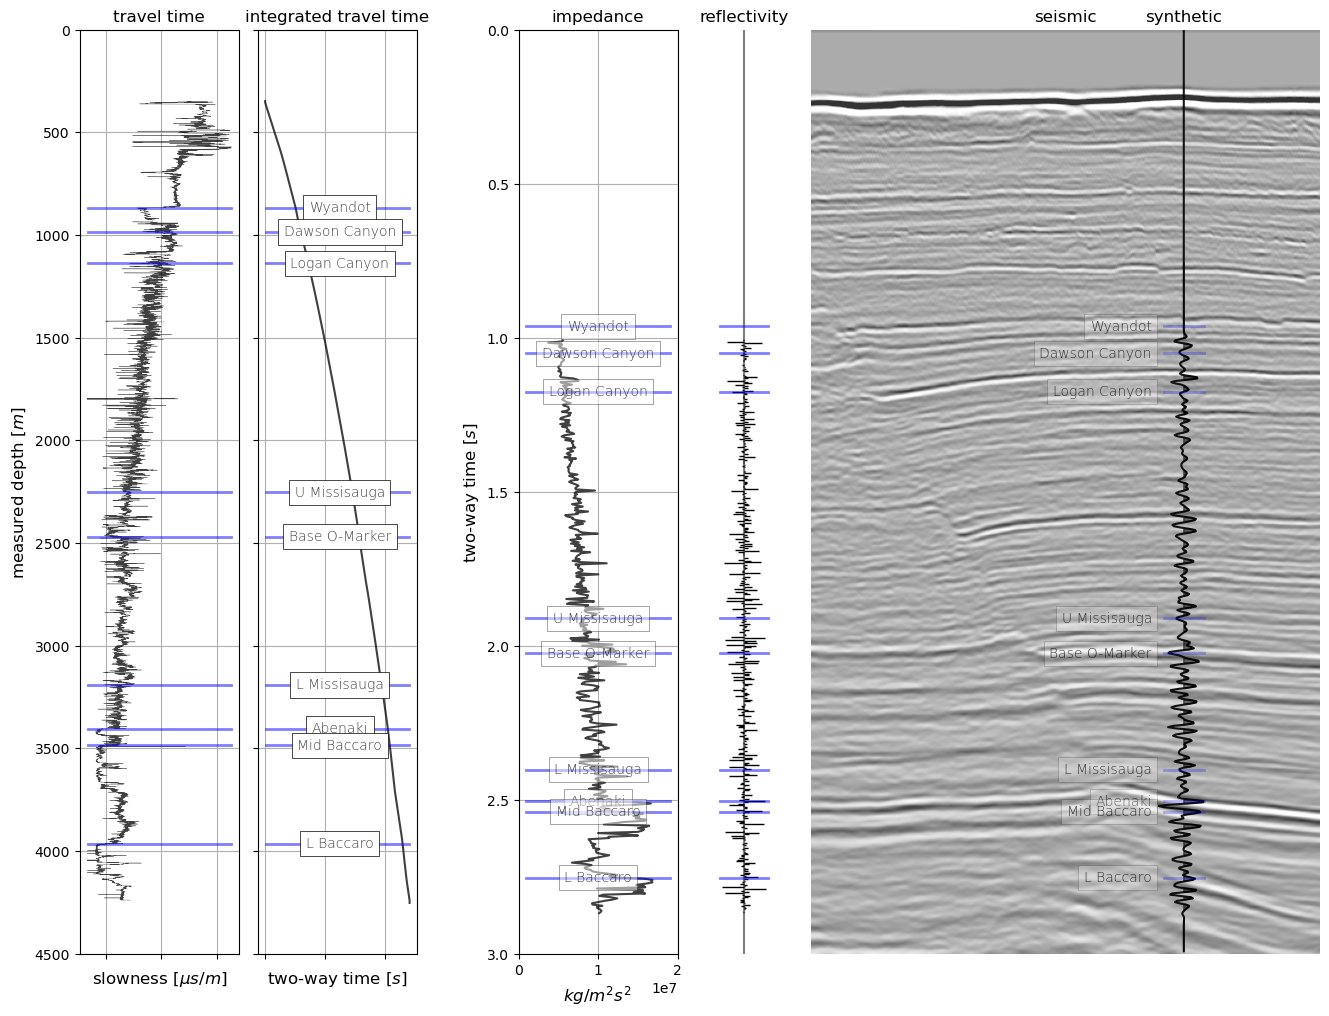

In [143]:
import matplotlib.gridspec as gridspec

f3 = plt.figure(figsize=[16,12])

gs = gridspec.GridSpec(1, 6, width_ratios = [1.25, 1.25, 0.5, 1.25, 0.75, 4])

# depth domain

axa = plt.subplot(gs[0])
axa.plot( DT, DEPTH,'k', alpha=0.75, lw=0.25)
axa.set_title('travel time')
axa.set_ylabel('measured depth ' + '$[m]$', fontsize = '12' )
axa.set_xlabel('slowness 'r'$[\mu s/m]$', fontsize = '12')
axa.set_ylim(0, 4500)
axa.set_xticklabels('')
axa.invert_yaxis()
axa.grid()
gs.update(wspace=0.1)

axb = plt.subplot(gs[1])
axb.plot(TCUM, DEPTH, 'k', alpha = 0.75)
axb.set_title('integrated travel time')
axb.set_xlabel('two-way time ' + '$[s]$', fontsize = '12')
axb.invert_yaxis()
axb.set_yticklabels('')
axb.set_xticklabels('')
axb.set_ylim(4500, 0)
axb.grid()

for top, depth in tops.items():
    axa.axhline( y = float(depth), color = 'b', lw = 2, 
                         alpha = 0.5, xmin = 0.05, xmax = 0.95 )
    axb.axhline( y = float(depth), color = 'b', lw = 2, 
                         alpha = 0.5, xmin = 0.05, xmax = 0.95 )
    axb.text( x = 1.25, y = float(depth)-0.015, s = top,
                         alpha=0.75, color='k',
                         fontsize = '10',
                         horizontalalignment = 'center',
                         verticalalignment = 'center',
                         bbox=dict(facecolor='white', alpha=1.0, lw = 0.5),
                         weight = 'light')

# time domain

#white space between depth and time plots
axoff = plt.subplot(gs[2])
axoff.set_axis_off()

axc = plt.subplot(gs[3])
axc.plot( Z_t, t, 'k', alpha=0.75)
axc.set_title('impedance')
axc.set_ylabel('two-way time '+ '$[s]$', fontsize = '12' )
axc.set_xlabel(r'$kg / m^2s^2$ ', fontsize = '12')
axc.set_ylim(0, 3)
axc.set_xlim(0, 2e7)
axc.invert_yaxis()
axc.grid()

for top, twt in tops_twt.items():
    axc.axhline( y = float(twt), color = 'b', lw = 2, 
                    alpha = 0.5, xmin = 0.05, xmax = 0.95)
    axc.text(x = 1e7, y = float(twt), s = top,
                        alpha=0.75, color='k',
                        fontsize = '10',
                        horizontalalignment = 'center',                             
                        verticalalignment = 'center',
                        bbox=dict(facecolor='white', alpha=0.5, lw = 0.5),
                        weight = 'light')     

axd = plt.subplot(gs[4])
axd.hlines(t[:-1], 0, RC_t, color='k', lw = 1)                    # Stems
axd.plot([0, 0], [t.min(), t.max()], '-', c='k', alpha = 0.5)     # Middle bar
axd.set_title('reflectivity')
axd.set_xlabel('', fontsize = '12')
axd.set_ylim(0, 3)
axd.set_xlim(-0.5, 0.5)
axd.invert_yaxis()
axd.set_yticklabels('')
axd.set_axis_off()
axd.grid()
for depth in tops_twt.values():
    axd.axhline(y = float(depth), color = 'b', lw = 2, 
                alpha = 0.5, xmin = 0.25, xmax = 0.75)

axe = plt.subplot(gs[5])
axe.imshow( traces[:750,100:], cmap = 'Greys', 
           vmin = -7000, vmax = 7000, alpha = 0.8,
           aspect = 'auto'
           )
axe.set_axis_off()
axe.set_title('seismic')

# put synthetic on seismic
bottom = axe.get_position().get_points()[0][1]
top =  axe.get_position().get_points()[1][1]

axf = axe.figure.add_axes([0.79, bottom, 0.05, top-bottom])
gain_synth = 1
axf.plot(gain_synth * synth, t[:-1], 'k', alpha = 0.9)
axf.fill_betweenx(t[:-1], gain_synth * synth,  0, 
                  gain_synth * synth > 0.0,
                  color = 'k', alpha = 0.5)
axf.set_title('synthetic')
axf.set_xlabel('', fontsize = '12')
axf.set_ylim(0, 3)
axf.set_xlim(-0.5 ,0.5)
axf.invert_yaxis()
axf.set_yticklabels('')
axf.set_axis_off()
axf.grid()
for top, twt in tops_twt.items():
    axf.axhline( y = float(twt), color = 'b', lw = 2, 
                alpha = 0.25, xmin = 0.25, xmax = 0.75)
    axf.text(x = -0.4, y = float(twt), s = top,
             alpha=0.75, color='k',
             fontsize = '10',
             horizontalalignment = 'right',
             verticalalignment = 'center',
             bbox=dict(facecolor='white', alpha=0.25, lw = 0.5),
             weight = 'light')
plt.show()
#f3.savefig('Figure_1.png', facecolor = 'white', dpi = 300)

## Loading a seismic volume (.sgy) and inspecting slices

For this task, we will use Equinor's [segyio](https://github.com/equinor/segyio) library which describes itself as follows:

> Segyio is a small LGPL licensed C library for easy interaction with SEG Y formatted seismic data, with language bindings for Python and Matlab. Segyio is an attempt to create an easy-to-use, embeddable, community-oriented library for seismic applications. Features are added as they are needed; suggestions and contributions of all kinds are very welcome.

It allows us to load 2D and 3D seismic, but of course with all the [usual caveats about the segy format](https://agilescientific.com/blog/2014/3/26/what-is-seg-y.html).

So let's first import and inspect a curated seismic cube:

** Informacion de F3 Dip Steered**

In [144]:
import segyio

filename = './data/F3_Dip_steered_median_subvolume_IL230-430_XL475-675_T1600-1800.sgy'
with segyio.open(filename) as s:
    # Extract attributes
    print(f"Number of traces: {s.tracecount}")
    print(f"Number of samples per trace: {s.samples.size}")
    print(f"Sample interval: {s.bin[segyio.BinField.Interval]} microseconds == 0.004 seconds")
    print(f"Inline range: {s.ilines.min()} to {s.ilines.max()}")
    print(f"Crossline range: {s.xlines.min()} to {s.xlines.max()}")
    c = segyio.cube(s)
type(c[0,0,0])

Number of traces: 40401
Number of samples per trace: 51
Sample interval: 4000 microseconds == 0.004 seconds
Inline range: 230 to 430
Crossline range: 475 to 675


numpy.float32

In [145]:
# What is the maximum absolute amplitude in the cube?
np.max(np.abs(c))

21683.0

In [146]:
# What is the minimum value different from zero in the cube?
np.min(np.abs(c[np.nonzero(c)]))

1.0

In [147]:
# Let's convert the convert the 32 bit floats to 16 bit integers to save memory
c = c.astype(np.int16)
type(c[0,0,0])

numpy.int16

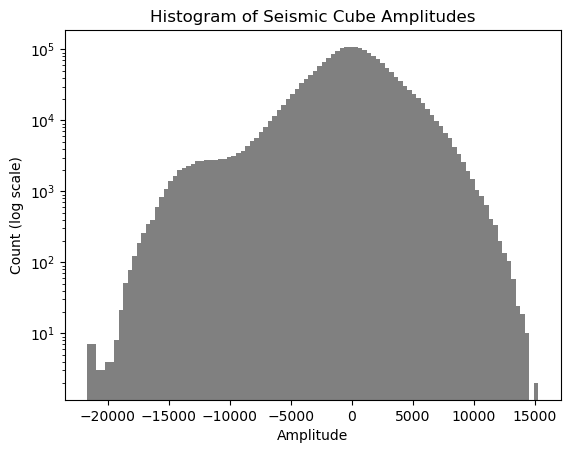

In [148]:
# Make a histogram of the inline amplitudes
plt.hist(c.flatten(), bins=100, color='gray')
plt.yscale('log')
plt.title('Histogram of Seismic Cube Amplitudes')
plt.xlabel('Amplitude')
plt.ylabel('Count (log scale)')
plt.show()

In [149]:
np.max(np.abs(c))

21683

In [150]:
c.shape

(201, 201, 51)

In [151]:
c[150, :, :].shape

(201, 51)

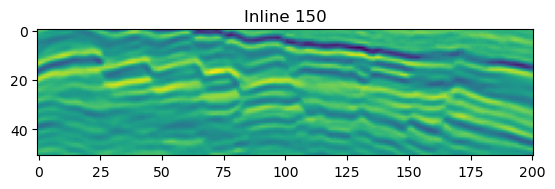

In [152]:
plt.imshow(c[150, :, :].T)
plt.title('Inline 150')
plt.show()

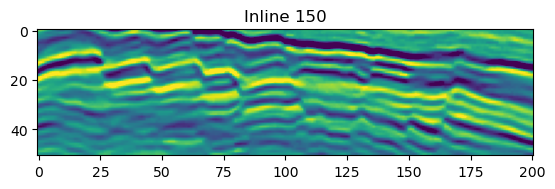

In [153]:
ma = np.percentile(c[150, :, :], 98)
plt.title('Inline 150')
plt.imshow(c[150, :, :].T, vmin=-ma, vmax=ma)
plt.show()

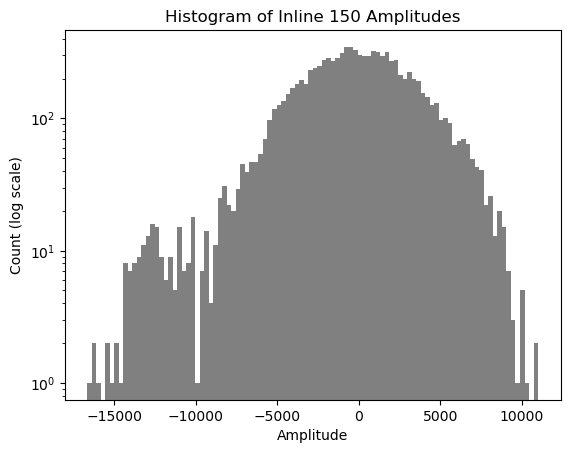

In [154]:
# Make a histogram of the inline amplitudes
plt.hist(c[150, :, :].flatten(), bins=100, color='gray')
plt.yscale('log')
plt.title('Histogram of Inline 150 Amplitudes')
plt.xlabel('Amplitude')
plt.ylabel('Count (log scale)')
plt.show()

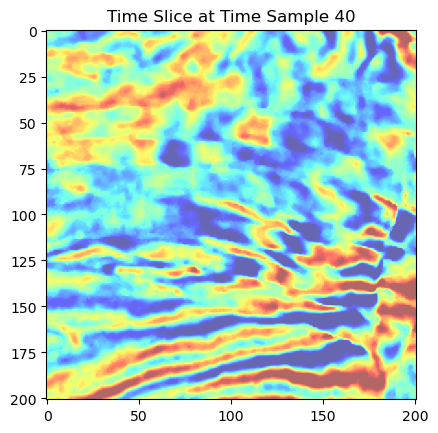

In [155]:
ma = np.percentile(c[:, :,40], 98)
plt.imshow(c[:, :,40].T, vmin=-ma, vmax=ma, cmap='jet', alpha=0.6) # 'Greys_r'
plt.title('Time Slice at Time Sample 40')
plt.show()

In [156]:
plt.colormaps()

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viri

## Scanning through a seismic volume interactively

As we did before, we can use `interact` to explore this cube on the fly, as long as it fits in memory of course. We will define a `seismic loading` function, a `seismic plotting` function, and finally call this plotting function with `interact`:

In [157]:
def load_seismic(filename):
    """
    Load a seismic cube
    Args:
        volume path
    Return:
        numpy array
    """
    with segyio.open(filename) as s:
        vol = segyio.cube(s).astype(np.int16)
    return vol

In [160]:
c.shape # (inlines, xlines, timeslices)

(201, 201, 51)

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

#----------------------------------------------------------
#  Multi-view seismic plotter (inline + xline + timeslice)
#----------------------------------------------------------
def seismic_plotter_all(colormap, inline, xline, timeslice, volume):
    """Plot inline, crossline, and time-slice together."""
    
    # load seismic volume
    vol = load_seismic(volume)  # <- your function
    
    # amplitude scaling
    ma = np.percentile(vol, 98)

    # extract sections
    inline_sec     = vol[inline, :, :].T
    xline_sec      = vol[:, xline, :].T
    timeslice_sec  = vol[:, :, timeslice]

    # figure
    fig, axes = plt.subplots(3, 1, figsize=(16, 18))

    # ----- INLINE -----
    im0 = axes[0].imshow(inline_sec, aspect=1, vmin=-ma, vmax=ma, cmap=colormap)
    axes[0].set_title(f"Inline {inline}", color='r')
    axes[0].axhline(y=timeslice, color='b')
    axes[0].axvline(x=xline,    color='g')

    # ----- XLINE -----
    im1 = axes[1].imshow(xline_sec, aspect=1, vmin=-ma, vmax=ma, cmap=colormap)
    axes[1].set_title(f"Crossline {xline}", color='g')
    axes[1].axhline(y=timeslice, color='b')
    axes[1].axvline(x=inline,    color='r')

    # ----- TIMESLICE -----
    im2 = axes[2].imshow(timeslice_sec, aspect='equal', vmin=-ma, vmax=ma, cmap=colormap)
    axes[2].set_title(f"Time-slice {timeslice}", color='b')
    axes[2].axhline(y=xline,     color='g')
    axes[2].axvline(x=inline,    color='r')

    # common colorbar
    fig.colorbar(im2, ax=axes.ravel().tolist(), shrink=0.4, label="Amplitude")
    
    plt.show()
    
_ = interact(
    seismic_plotter_all,
    
    colormap=['Greys', 'Greys_r', 'seismic', 'seismic_r', 'viridis', 'plasma', 'inferno', 'magma'],

    inline=widgets.IntSlider(
        value=100, min=0, max=201, step=1, continuous_update=True,
        description='<font color="red">inline</>'
    ),

    xline=widgets.IntSlider(
        value=100, min=0, max=201, step=1, continuous_update=True,
        description='<font color="green">xline</>'
    ),

    timeslice=widgets.IntSlider(
        value=25, min=0, max=51, step=1, continuous_update=True,
        description='<font color="blue">timeslice</>'
    ),

    volume=filename  # <- your SEG-Y cube
)


interactive(children=(Dropdown(description='colormap', options=('Greys', 'Greys_r', 'seismic', 'seismic_r', 'v…